# Ch. 8. Difference of Biases of Two Coins
- Bernoulli likelihood model
- This part is related to 'Bayesian' NHST in Chapter 11.
- MCMC for two coin experiment
- Comparison by distribution of sample difference
- Prior Predictive Check 

In [1]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [2]:
import os

import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import scipy
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import arviz
#sns.set_style("darkgrid"); 

# plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# plt.style.use("dark_background")

In [3]:
df = pd.read_csv('Data/z6N8z2N7.csv', dtype={'s': 'category'})  # y, subject
df

,y,s
0,1,Reginald
1,0,Reginald
2,1,Reginald
3,1,Reginald
4,1,Reginald
5,1,Reginald
6,1,Reginald
7,0,Reginald
8,0,Tony
9,0,Tony


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['coin_id'] = le.fit_transform(df.s) # make an id number for each subject
n_coins = len(df.s.unique())
print('n_coins = ', n_coins)
df

n_coins =  2


,y,s,coin_id
0,1,Reginald,0
1,0,Reginald,0
2,1,Reginald,0
3,1,Reginald,0
4,1,Reginald,0
5,1,Reginald,0
6,1,Reginald,0
7,0,Reginald,0
8,0,Tony,1
9,0,Tony,1


## Modeling with Bernoulli Likelihood

In [5]:
def model(n_coins, y=None, coin_id=None):
    with numpyro.plate('plate', size=n_coins):  # for loop
        theta = numpyro.sample('theta', dist.Beta(2,2))  # for each theta
#     print('theta', theta.shape, coin_id.shape, coin_id)
    theta_subj = theta[coin_id]
    obs = numpyro.sample('obs', dist.Bernoulli(probs=theta_subj), obs=y)
#

In [6]:
rng_key = random.PRNGKey(0)
# run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=40000, num_chains=1,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
mcmc.run(rng_key, n_coins, df.y.values, df.coin_id.values)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 41000/41000 [00:34<00:00, 1197.10it/s, 7 steps of size 7.65e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.67      0.13      0.68      0.46      0.88  28503.85      1.00
  theta[1]      0.36      0.14      0.36      0.13      0.58  31312.72      1.00

Number of divergences: 0


In [7]:
samples = mcmc.get_samples()
samples 

{'theta': DeviceArray([[0.4349147 , 0.10061472],
              [0.4980152 , 0.14742094],
              [0.5355934 , 0.3911616 ],
              ...,
              [0.6722401 , 0.5123139 ],
              [0.41848224, 0.57194895],
              [0.8614593 , 0.13452993]], dtype=float32)}

In [8]:
azdata = arviz.from_numpyro(mcmc)

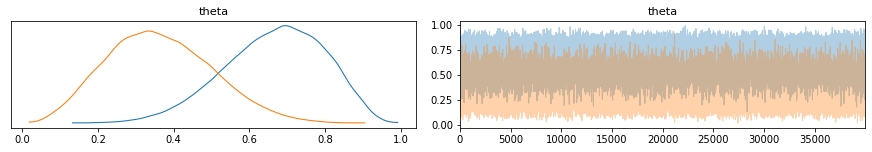

In [9]:
arviz.plot_trace(azdata);

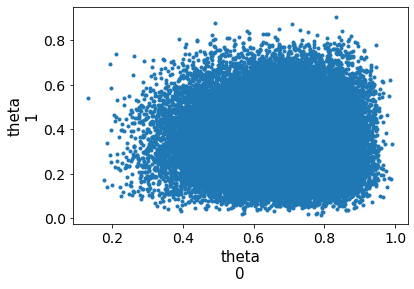

In [10]:
arviz.plot_pair(azdata, );

In [11]:
#%%writefile myutils.py 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import arviz

def plot_pairs(sample_dicts, key, key_obs=None, hdi_prob=.95, kind='hist'):
    s = np.array(sample_dicts[key])
    n = s.shape[1]
    fig, axes = plt.subplots(n, n, figsize=(4*n, 3*n))
    for i in range(n):
        for j in range(n):
            ax = axes[i,j]
            if i == j:
                arviz.plot_posterior(s[:,i], hdi_prob=hdi_prob, point_estimate='mode', kind=kind, bins=50, ax=ax)
                ax.set(title='', xlabel=f'{key}[{i}]')
                if key_obs is not None:
                    ax.plot(key_obs[i], .01, 'r+', markersize=15)
            elif i > j:
                ax.scatter(s[:,j], s[:,i], alpha=.5, s=9)
                ax.set(title='', xlabel=f'{key}[{j}]', ylabel=f'{key}[{i}]')
            else: # i < j
                diff = s[:,i] - s[:,j]
                arviz.plot_posterior(diff, hdi_prob=.95, ref_val=0., point_estimate='mode', kind=kind, bins=50, ax=ax)
                ax.set(title='', xlabel=f'{key}[{i}] - {key}[{j}]')
                ax.plot(diff.mean(), .01, 'r+', markersize=15)
    fig.tight_layout()
#

def plot_hists(samples):
    ns, nplots = samples.shape
    fig, axes = plt.subplots(1, nplots, figsize=(4*nplots, 3))
    for i, ax in enumerate(axes):
        sns.histplot(samples[:,i], ax=ax)
    fig.tight_layout()
    return axes

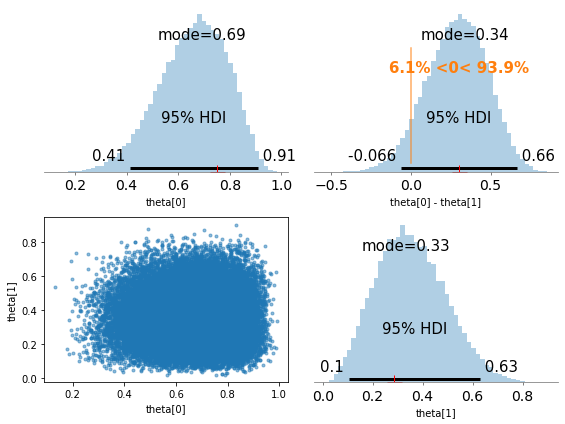

In [12]:
plot_pairs(samples, 'theta', key_obs=[6/8., 2/7.])

---
## Posterior Predictive Check

In [13]:
%%time 
thetas = mcmc.get_samples()['theta'][:,0]
x = np.array([scipy.stats.bernoulli(p=th).rvs(8) for th in thetas])
x.shape    

CPU times: user 20.7 s, sys: 80.8 ms, total: 20.8 s
Wall time: 20.5 s


(40000, 8)

CPU times: user 94.9 ms, sys: 0 ns, total: 94.9 ms
Wall time: 93.2 ms


<AxesSubplot:ylabel='Count'>

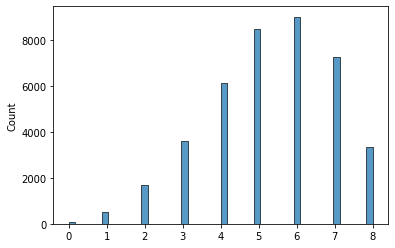

In [14]:
%%time
x = scipy.stats.bernoulli.rvs(p=thetas, size=(8,len(thetas)))
x.shape
xsum = x.sum(axis=0)
sns.histplot(xsum);

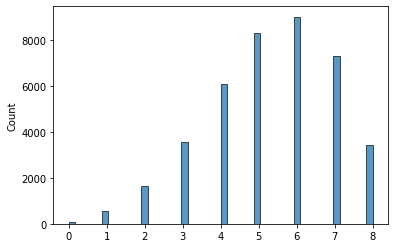

In [15]:
# the same as about but with JAX
x = jax.random.bernoulli(random.PRNGKey(0), p=thetas, shape=(8,len(thetas)))
sns.histplot(x.sum(axis=0));

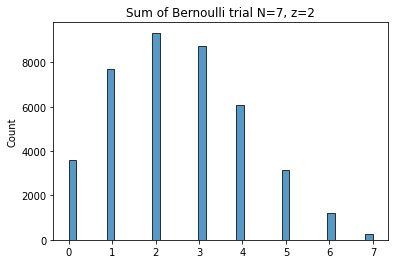

In [16]:
# second coin
thetas = mcmc.get_samples()['theta'][:,1]
x = jax.random.bernoulli(random.PRNGKey(1), p=thetas, shape=(7, len(thetas)))
ax = sns.histplot(x.sum(axis=0));
ax.set(title='Sum of Bernoulli trial N=7, z=2');

---
## Prior Predictive Check

In [17]:
predictive = Predictive(model, num_samples=20210)
samples_predictive = predictive(random.PRNGKey(0), n_coins)  # without observation
samples_predictive                               

{'obs': DeviceArray([[[1, 1]],
 
              [[0, 1]],
 
              [[1, 0]],
 
              ...,
 
              [[0, 1]],
 
              [[0, 0]],
 
              [[1, 0]]], dtype=int32),
 'theta': DeviceArray([[0.6547753 , 0.87225807],
              [0.3097056 , 0.7058706 ],
              [0.6430784 , 0.3620636 ],
              ...,
              [0.292965  , 0.43549284],
              [0.5256881 , 0.47805414],
              [0.74603456, 0.33761546]], dtype=float32)}

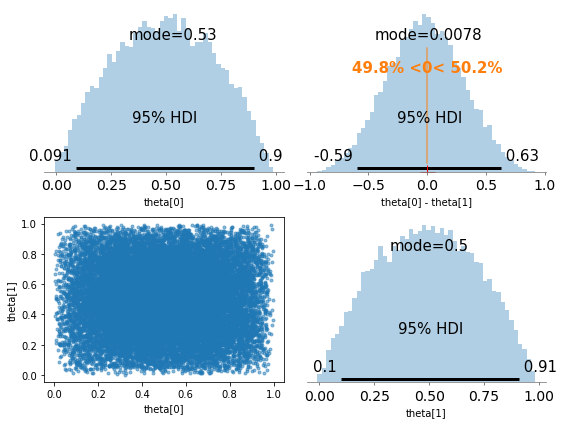

In [18]:
plot_pairs(samples_predictive, 'theta')

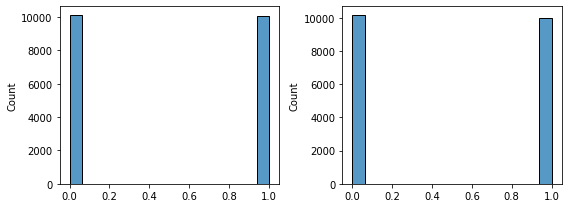

In [19]:
plot_hists(samples_predictive['obs'][:,0,:]);

End.

---
## Save the utility functions into a file and import

In [20]:
%%writefile myutils.py 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import arviz

def plot_pairs(sample_dicts, key, key_obs=None, hdi_prob=.95, kind='hist'):
    s = np.array(sample_dicts[key])
    n = s.shape[1]
    fig, axes = plt.subplots(n, n, figsize=(4*n, 3*n))
    for i in range(n):
        for j in range(n):
            ax = axes[i,j]
            if i == j:
                arviz.plot_posterior(s[:,i], hdi_prob=hdi_prob, point_estimate='mode', kind=kind, bins=50, ax=ax)
                ax.set(title='', xlabel=f'{key}[{i}]')
                if key_obs is not None:
                    ax.plot(key_obs[i], .01, 'r+', markersize=15)
            elif i > j:
                ax.scatter(s[:,j], s[:,i], alpha=.5, s=9)
                ax.set(title='', xlabel=f'{key}[{j}]', ylabel=f'{key}[{i}]')
            else: # i < j
                diff = s[:,i] - s[:,j]
                arviz.plot_posterior(diff, hdi_prob=.95, ref_val=0., point_estimate='mode', kind=kind, bins=50, ax=ax)
                ax.set(title='', xlabel=f'{key}[{i}] - {key}[{j}]')
                ax.plot(diff.mean(), .01, 'r+', markersize=15)
    fig.tight_layout()
#

def plot_hists(samples):
    ns, nplots = samples.shape
    fig, axes = plt.subplots(1, nplots, figsize=(4*nplots, 3))
    for i, ax in enumerate(axes):
        sns.histplot(samples[:,i], ax=ax)
    fig.tight_layout()
    return axes

Overwriting myutils.py


In [21]:
import myutils as mu

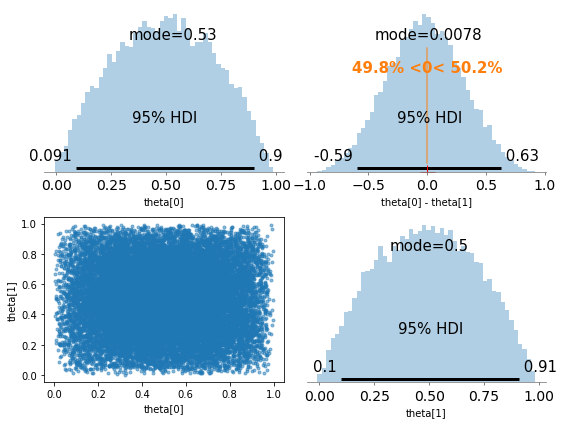

In [22]:
mu.plot_pairs(samples_predictive, 'theta')